# Обучение нейросети на датасете CIFAR-10

In [31]:
import lasagne
import os
import pickle
import theano

import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as T

from sklearn.cross_validation import train_test_split

In [32]:
%matplotlib inline

## Подготовка данных

### Вспомогательные процедуры

In [33]:
def deserialize_batch_from_py2(file_path):
    if not os.path.exists(file_path):
        raise ValueError('Невозможно открыть файл {}'.format(file_path))

    with open(file_path, mode='rb') as fp:
        u = pickle._Unpickler(fp)
        u.encoding = 'latin1'
        unpickled = u.load()

    return unpickled

### Чтение данных из батчей

In [54]:
data_path = os.path.join(os.getcwd(), 'batches')

X_train, y_train = list(), list()
X_test, y_test = list(), list()

for item in os.listdir(data_path):
    if os.path.splitext(item)[1]:
        continue
        
    try:
        data = deserialize_batch_from_py2(os.path.join(data_path, item))
    except ValueError as ve:
        print(ve)
        exit(0)
        
    if item == 'test_batch':
        X, y = X_test, y_test
    else:
        X, y = X_train, y_train
    
    X.append(data['data'])
    y.append(data['labels'])
    
X_train, y_train = np.concatenate(X_train).reshape(-1, 3, 32, 32).astype(np.int32),\
                       np.concatenate(y_train).astype(np.int32)
X_test, y_test = np.concatenate(X_test).reshape(-1, 3, 32, 32).astype(np.int32),\
                     np.concatenate(y_test).astype(np.int32)

### Нормализация

In [55]:
mean, std = np.mean(np.concatenate((X_train, X_test), axis=0), 0),\
            np.std(np.concatenate((X_train, X_test), axis=0), 0).clip(min=1)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

### Разделение обучающей выборки на train и val

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2,
                                                  random_state=42)

## Создание нейросети

In [37]:
N_FILTERS = 100

def build_cnn(input_var=None,
              crp_num_filters=64, crp_filter_size=3,):
    
    network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
            network, 
            num_filters = 4 * N_FILTERS, 
            filter_size = (3, 3),
            nonlinearity = lasagne.nonlinearities.rectify,
            W = lasagne.init.GlorotUniform())

    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    network = lasagne.layers.Conv2DLayer(
            network, 
            num_filters = 2 * N_FILTERS,
            filter_size = (3, 3),
            nonlinearity = lasagne.nonlinearities.rectify,
            W = lasagne.init.GlorotUniform(gain='relu'))

    network = lasagne.layers.Conv2DLayer(
            network, 
            num_filters = N_FILTERS,
            filter_size = (3, 3),
            nonlinearity = lasagne.nonlinearities.rectify,
            W = lasagne.init.GlorotUniform(gain='relu'))
    
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=128,
            nonlinearity=lasagne.nonlinearities.rectify)

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=64,
            nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network
    

def compile_cnn():
    X_sym = T.tensor4('input_var')
    y_sym = T.ivector('target_var')
    
    cnn = build_cnn(X_sym)
    
    '''
    Для обучения
    '''
    
    y_pred = lasagne.layers.get_output(cnn)
    params = lasagne.layers.get_all_params(cnn, trainable=True)
    
    loss = lasagne.objectives.aggregate(lasagne.objectives.categorical_crossentropy(y_pred, y_sym))
    
    cost = T.grad(loss, params)
    
    updates = lasagne.updates.nesterov_momentum(cost, params, learning_rate=0.001)
    
    '''
    Для тестирования
    '''
    
    test_pred = lasagne.layers.get_output(cnn, deterministic=True)
    
    test_loss = lasagne.objectives.aggregate(lasagne.objectives.categorical_crossentropy(test_pred, y_sym))
    test_acc = T.mean(T.eq(T.argmax(test_pred, axis=1), y_sym))
    
    model_pred = test_pred.argmax(-1)
    
    '''
    Построение функций
    '''
    
    train_f = theano.function([X_sym, y_sym], loss, updates=updates, allow_input_downcast=True)
    
    val_f = theano.function([X_sym, y_sym], [test_loss, test_acc], allow_input_downcast=True)
    
    pred_f = theano.function([X_sym], model_pred, allow_input_downcast=True)
    
    return cnn, train_f, val_f, pred_f

## Обучение нейросети

### Вспомогательные функции

In [38]:
def iterate_minibatches(X, y, batch_size, shuffle=True):
    if len(X) != len(y):
        raise ValueError('Количество объектов X должно быть равно количеству меток класса у')
        
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        
    for start_idx in range(0, len(X) - batch_size - 1, batch_size):
        if shuffle:
            chunk = indices[start_idx:(start_idx + batch_size)]
        else:
            chunk = slice(start_idx, start_idx + batch_size)
            
        yield X[chunk], y[chunk]

### Вспомогательные константы

In [39]:
BATCH_SIZE = 32

n_eras = 20

### Обучение

In [40]:
cnn, train_f, val_f, pred_f = compile_cnn()

C:\Program Files (x86)\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\site-packages\lasagne\layers\pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
C:\Program Files (x86)\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\site-packages\lasagne\layers\pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
C:\Program Files (x86)\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\site-packages\lasagne\layers\pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [41]:
era_params, errors, accuracies = list(), list(), list()

for era in range(n_eras):
    ''' Train '''
    
    train_err, n_trained_batches = (0, ) * 2
    
    for X, y in iterate_minibatches(X_train, y_train, BATCH_SIZE):
        train_err += train_f(X, y)
        
        n_trained_batches += 1
        
    ''' Val '''
    val_err, val_acc, n_val_batches = (0, ) * 3
    
    for X, y in iterate_minibatches(X_val, y_val, BATCH_SIZE, shuffle=False):
        err, acc = val_f(X, y)
        
        val_err += err
        val_acc += acc
        
        n_val_batches += 1
        
    ''' Output '''
        
    train_err /= n_trained_batches
    
    val_err /= n_val_batches
    val_acc /= n_val_batches
    
    errors.append(val_err)
    accuracies.append(val_acc)
    
    era_params.append(lasagne.layers.get_all_param_values(cnn))
    
    print('Era {}, train_err = {}, val_err = {}, acc = {}'.format(era + 1,
                                                                  train_err,
                                                                  val_err,
                                                                  val_acc))

Era 1, train_err = 2.1682580840215384, val_err = 1.8399014564660878, acc = 0.3613782051282051
Era 2, train_err = 1.8661858418925081, val_err = 1.627151934382243, acc = 0.4143629807692308
Era 3, train_err = 1.7013711947455608, val_err = 1.5145884587978706, acc = 0.44711538461538464
Era 4, train_err = 1.5935050864234936, val_err = 1.385707092972902, acc = 0.5013020833333334
Era 5, train_err = 1.518570832866397, val_err = 1.3226580096360965, acc = 0.5154246794871795
Era 6, train_err = 1.451696951690915, val_err = 1.2944467147955527, acc = 0.5261418269230769
Era 7, train_err = 1.4000557786565098, val_err = 1.202103360532186, acc = 0.5679086538461539
Era 8, train_err = 1.3487547636509323, val_err = 1.1702291931097324, acc = 0.5814302884615384
Era 9, train_err = 1.3020121933843156, val_err = 1.1483747387925785, acc = 0.5899439102564102
Era 10, train_err = 1.2621970339905653, val_err = 1.1024807114631703, acc = 0.6097756410256411
Era 11, train_err = 1.2270704805135155, val_err = 1.06440005814

### Выбор и сохранение модели с наилучшими параметрами

In [42]:
max_acc_idx = np.argmax(accuracies)

if max_acc_idx is not None:
    best_model_params = era_params[max_acc_idx]
    
    with open('model.dat', mode='wb') as f:
        pickle.dump(best_model_params, f)

### Визуализация ошибки при обучении

In [43]:
import seaborn as sns

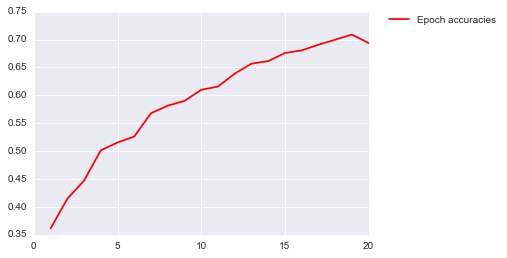

In [64]:
eras = [x + 1 for x in range(n_eras)]

figure = plt.figure(1)

ax = figure.add_subplot(111)

ax.plot(eras, accuracies, label='Epoch accuracies', color='red')

handlers, labels = ax.get_legend_handles_labels()

ax.legend(handlers, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.grid('on')

plt.show()

## Оценка точности работы модели

In [61]:
with open('model.dat', mode='rb') as f:
    params = pickle.load(f)
    
cnn, *other = compile_cnn()
    
lasagne.layers.set_all_param_values(cnn, params)

y_pred = list()

for X in X_test:
    y_pred.append(pred_f([X])[0])

C:\Program Files (x86)\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\site-packages\lasagne\layers\pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
C:\Program Files (x86)\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\site-packages\lasagne\layers\pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
C:\Program Files (x86)\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\site-packages\lasagne\layers\pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


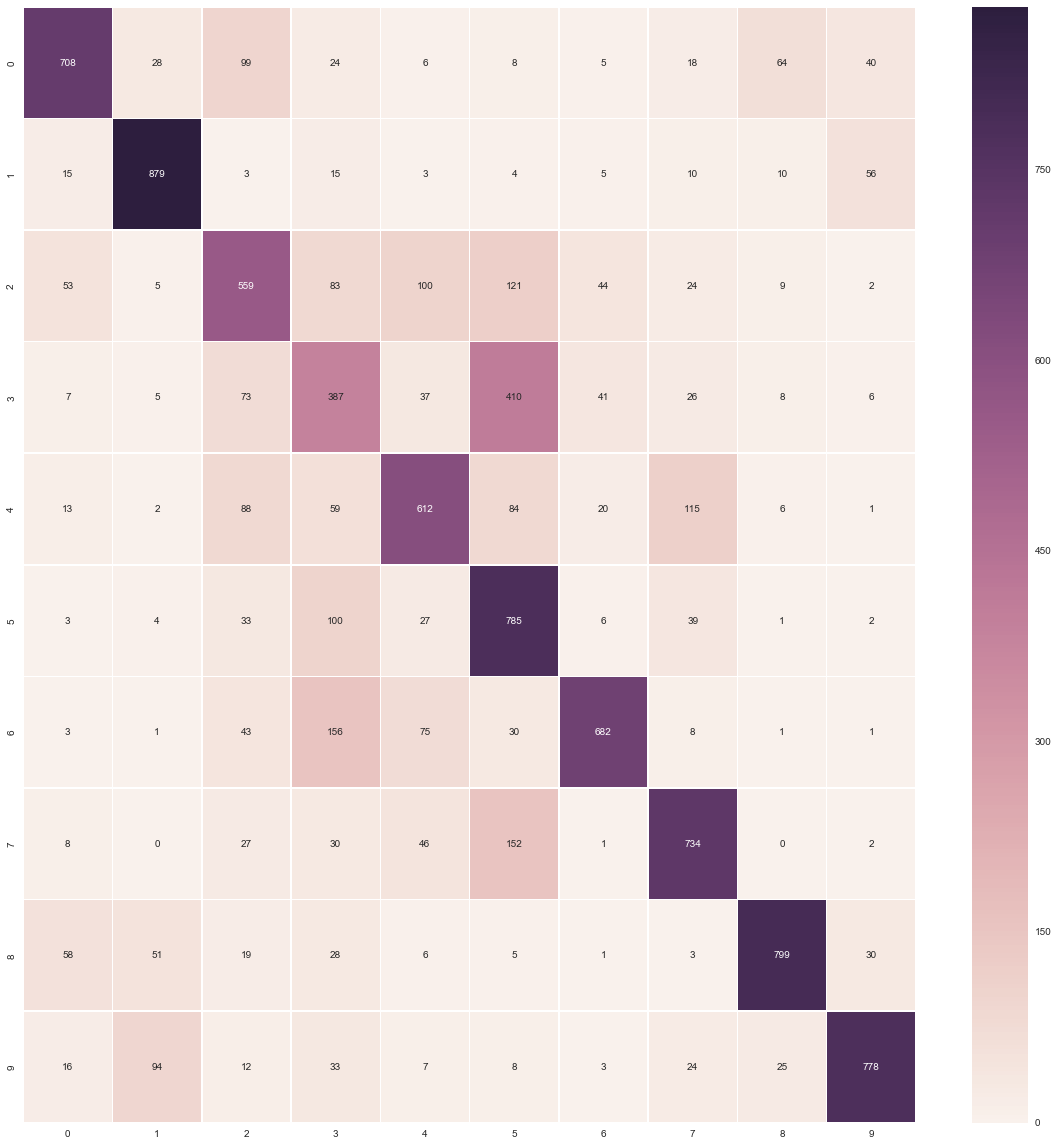

In [63]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', linewidth=0.5)
plt.show()